Using GPU : Quadro RTX 8000 (ID 0)


/state/partition1/job-64460739/ipykernel_315329/2607906080.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  annx_ckpt = torch.load(CKPT_ANN_X, map_location="cpu")
/stat

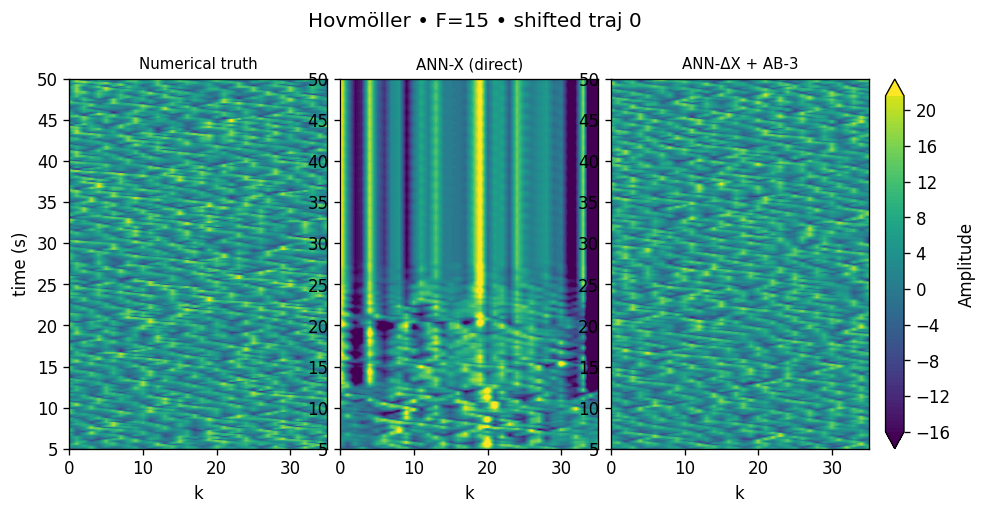

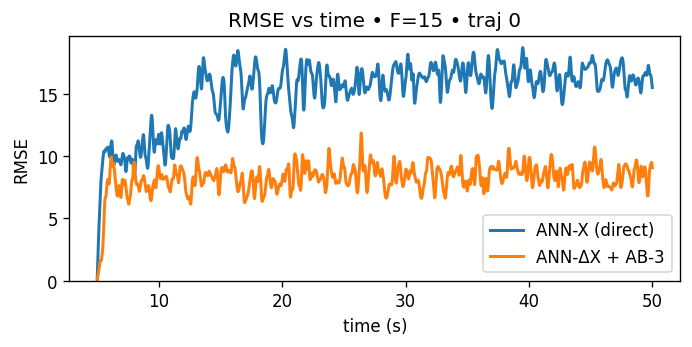

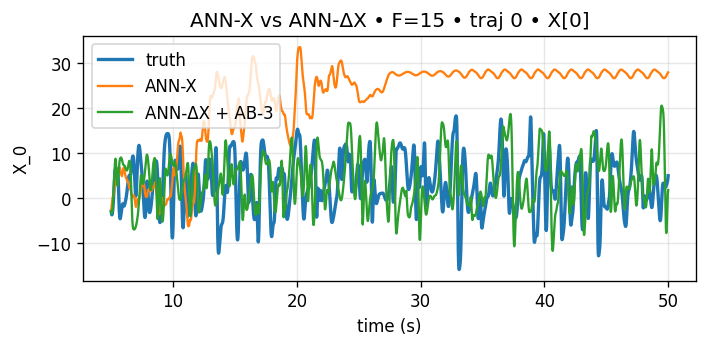

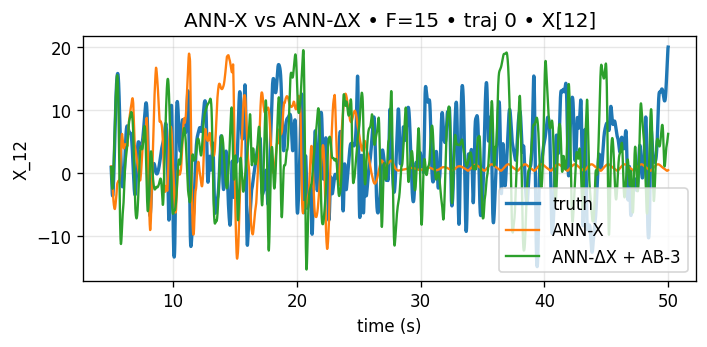

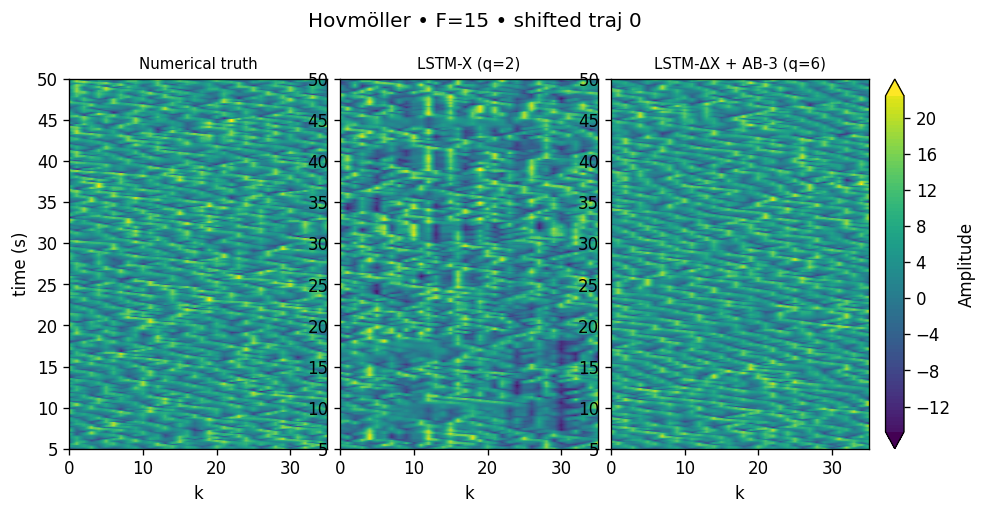

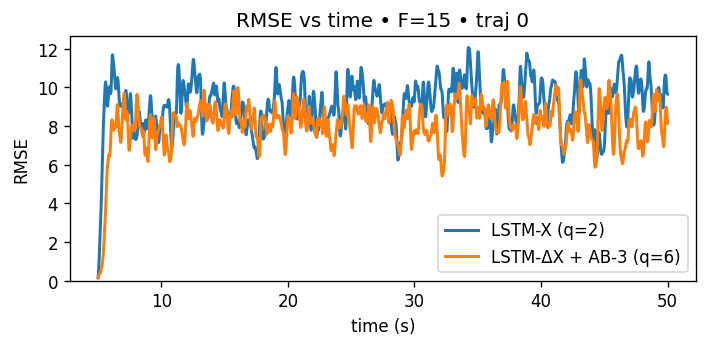

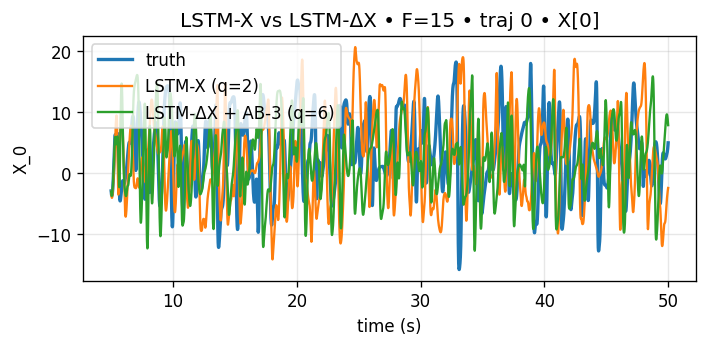

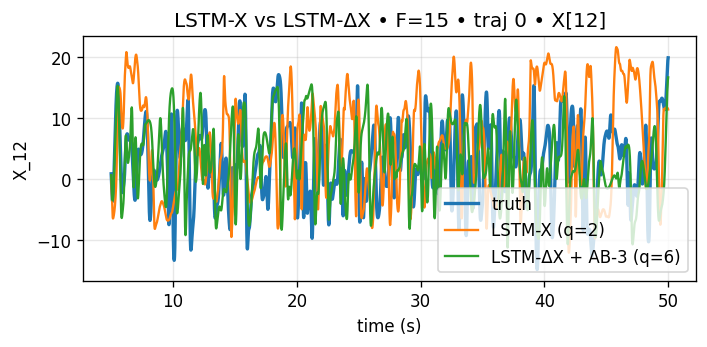

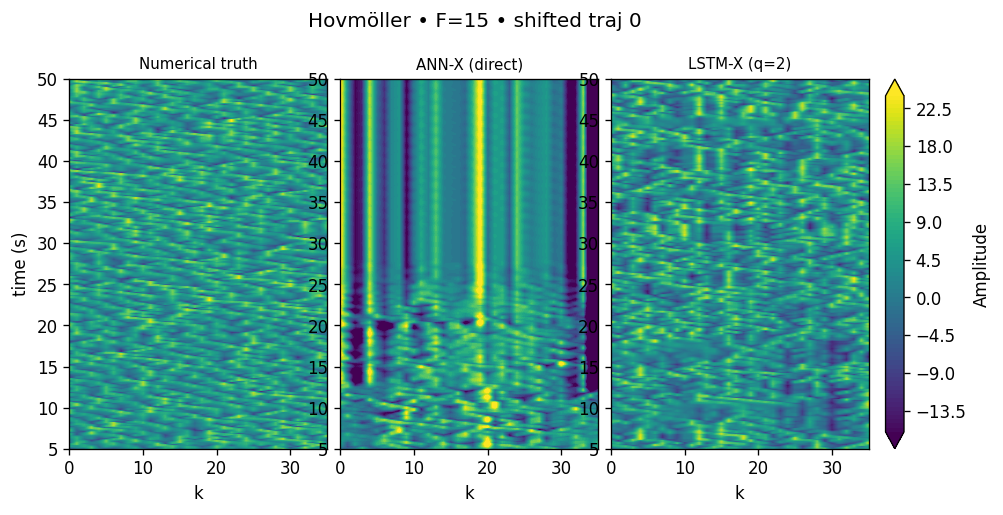

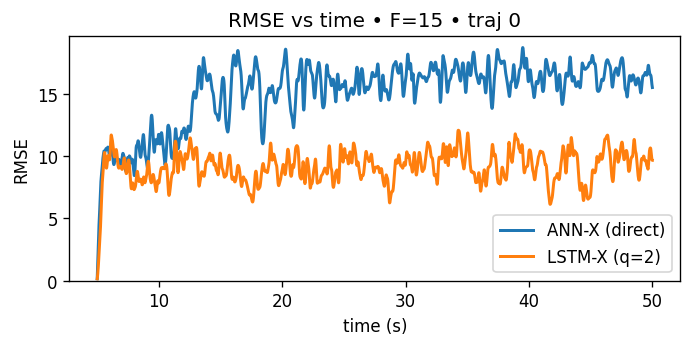

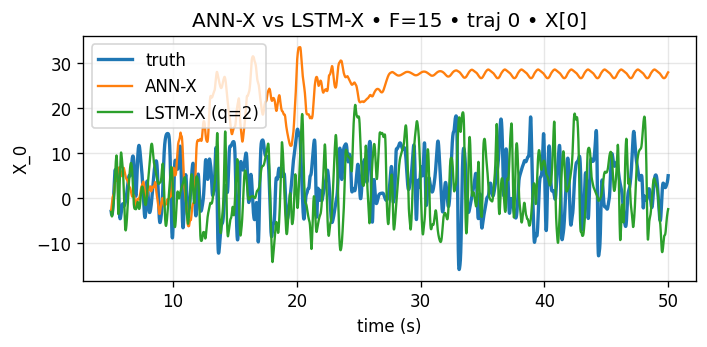

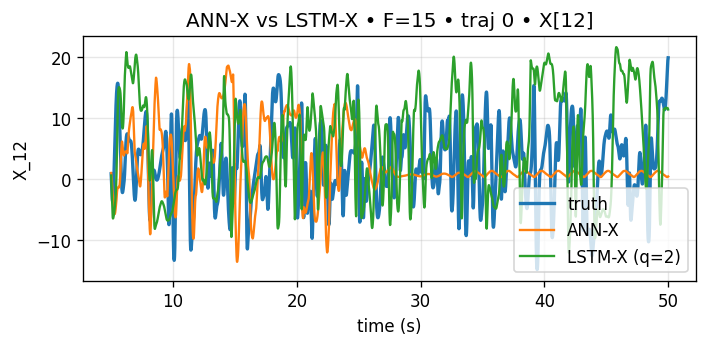

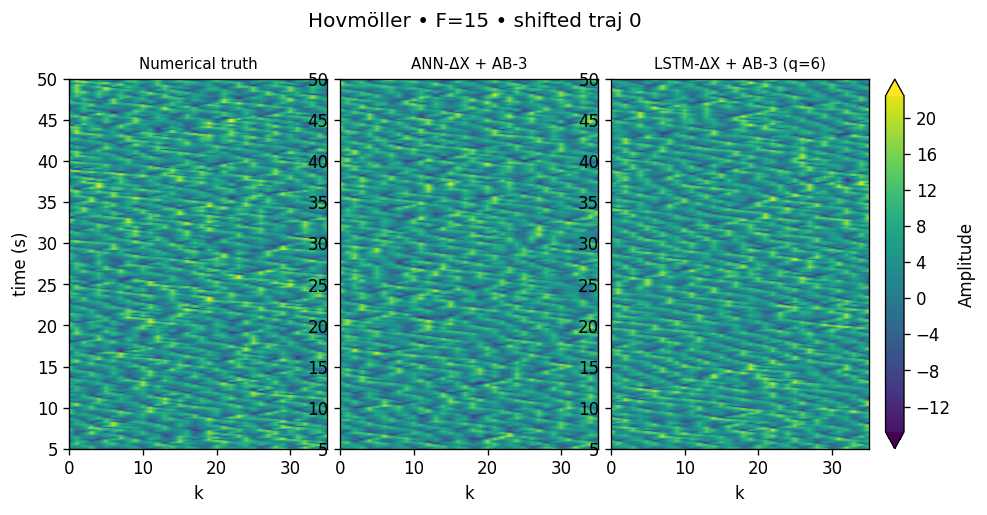

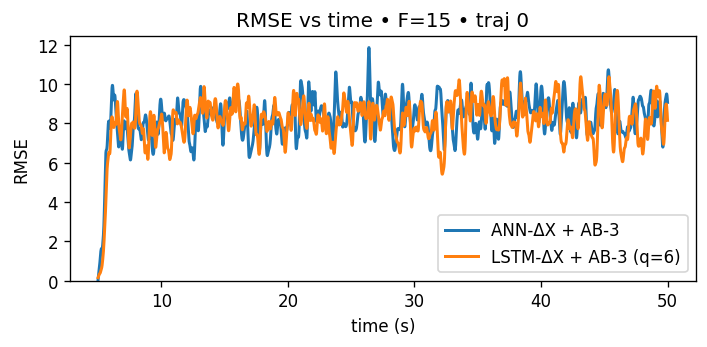

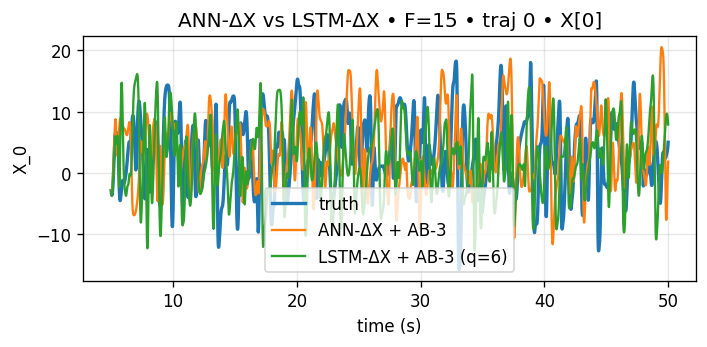

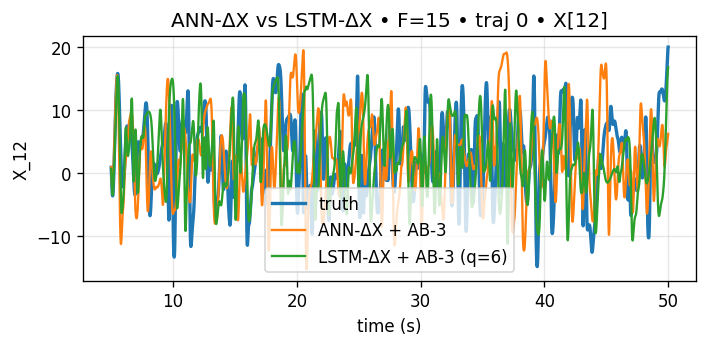


Computing ensemble-mean MAE(t) over 20 shifted trajectories …


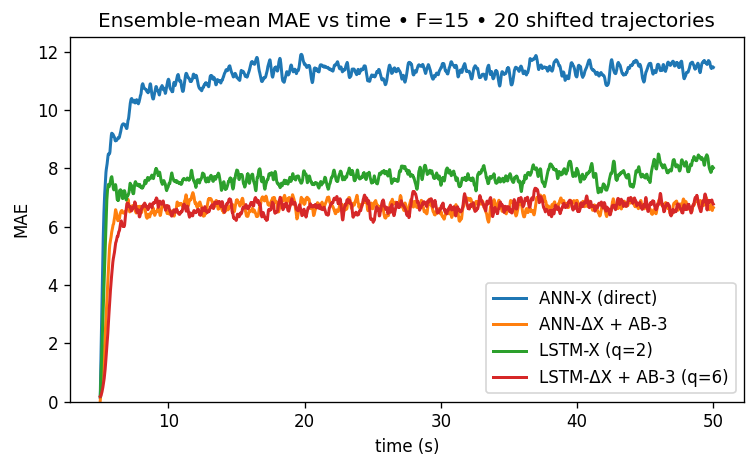


Done.


In [1]:
#!/usr/bin/env python3
# =============================================================================
#  Quantitative comparison suite (single-implicit) — F = 5 by default
#  -----------------------------------------------------------------------------
#  What this script does (for one fixed shifted trajectory + 20-trajectory eval):
#    (1) NUM vs ANN-X vs ANN-ΔX      — Hovmöller; RMSE(t); X[k] traces
#    (2) NUM vs LSTM-X vs LSTM-ΔX    — Hovmöller; RMSE(t); X[k] traces
#    (3) NUM vs ANN-X vs LSTM-X      — Hovmöller; RMSE(t); X[k] traces
#    (4) NUM vs ANN-ΔX vs LSTM-ΔX    — Hovmöller; RMSE(t); X[k] traces
#    (5) Ensemble-mean MAE(t) over 20 shifted trajectories for:
#            ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
#
#  Inputs (set manually below to match your files):
#    • TRAIN_FILE    : the training set (μ/σ fallback)
#    • SHIFTED_FILE  : shifted trajectories (truth for quantitative eval)
#    • CKPT_ANN_X    : ANN-X checkpoint    (direct X̂, one-step)
#    • CKPT_ANN_DX   : ANN-ΔX checkpoint   (ΔX̂, use AB-3 in z-space)
#    • CKPT_LSTM_X   : LSTM-X checkpoint   (direct X̂, window length q)
#    • CKPT_LSTM_DX  : LSTM-ΔX checkpoint  (ΔX̂, window length q, AB-3 in z-space)
#
#  Notes:
#    • ΔX models (ANN-ΔX & LSTM-ΔX) are integrated with Euler→AB2→AB3 **in z-space**.
#    • Direct X models (ANN-X & LSTM-X) do **not** use AB methods; they predict X̂(t+Δt).
#    • All rollouts are autoregressive and denormalise to physical space before metrics.
#    • Hovmöller/trace panels fix the trajectory index (TRAJ_IDX) and k’s (K_TO_PLOT).
#    • Ensemble-mean MAE(t) uses the first 20 trajectories in SHIFTED_FILE.
# =============================================================================

import os, re, numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ────────────────────────── USER CONFIG ────────────────────────────────────
# Forcing label is only for plot titles (truth comes from SHIFTED_FILE).
FORCE_LABEL   = 15                      # used in titles only (5, 10, or 15)

# Files (edit to your actual names)
TRAIN_FILE    = "force_15_data.npz"                 # μ/σ fallback
SHIFTED_FILE  = "shifted_force15_data.npz"          # unseen shifted trajectories
CKPT_ANN_X    = "standard_early_stopping_force15_annX.pt"
CKPT_ANN_DX   = "standard_early_stopping_force15_ann.pt"       # ΔX-ANN
CKPT_LSTM_X   = "standard_early_stopping_force15_LSTM_H70_q2.pt"
CKPT_LSTM_DX  = "standard_early_stopping_force15_LSTM_dX_H70_q6.pt"

# If a LSTM checkpoint lacks 'lookback' in its metadata and filename has no _q{q},
# set these overrides; otherwise leave as None.
Q_OVERRIDE_X  = None         # e.g., 7
Q_OVERRIDE_DX = None         # e.g., 7

# Time window & plotting
DT, T0, T1    = 0.005, 5.0, 50.0
TRAJ_IDX      = 0                          # fixed trajectory to showcase
K_TO_PLOT     = (0, 12)                    # two components for line plots

# Device
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ────────────────────────── TIME AXES ──────────────────────────────────────
steps_per_s = int(round(1/DT))
i0, i_end   = int(T0*steps_per_s), int(T1*steps_per_s)         # inclusive span
t_axis      = np.arange(i0, i_end+1, dtype=np.float32) * DT

# ────────────────────────── LOAD TRUTH ─────────────────────────────────────
X_shift_all = np.load(SHIFTED_FILE)["X"].astype(np.float32)    # (traj, step, 36)
N_TRAJ, N_STEPS, N = X_shift_all.shape
assert TRAJ_IDX < N_TRAJ, "TRAJ_IDX out of range for SHIFTED_FILE"
assert i_end + 1 <= N_STEPS, "Requested [T0,T1] exceeds data length"
truth_fixed = X_shift_all[TRAJ_IDX, i0:i_end+1]                # (T,N)

# μ/σ fallback
train = np.load(TRAIN_FILE)["X"].astype(np.float32).reshape(-1, N)
MU_FALL = train.mean(0).astype(np.float32)
SD_FALL = (train.std(0) + 1e-8).astype(np.float32)

# ────────────────────────── HELPERS ────────────────────────────────────────
def parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def find_state_dict(obj):
    """Locate a state_dict in a checkpoint object."""
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        # direct dict-of-tensors?
        if len(obj) and all(isinstance(v, (torch.Tensor, np.ndarray)) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = find_state_dict(v)
                if sd is not None:
                    return sd
    return None

# Adam-Bashforth 3 in z-space (Euler → AB2 → AB3)
def ab3(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:  # Euler
        return dx1
    if dx_prev2 is None:  # AB2
        return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

# ────────────────────────── MODELS ─────────────────────────────────────────
def make_mlp(sizes=(36,128,128,64,36), act="relu"):
    acts = dict(tanh=nn.Tanh, relu=nn.ReLU, gelu=nn.GELU)
    layers = []
    for i in range(len(sizes)-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if i < len(sizes)-2:
            layers.append(acts[act]())
    return nn.Sequential(*layers)

class LSTM_X(nn.Module):
    """One-layer LSTM that outputs next-state X̂ (normalised)."""
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):              # w: (B,q,N) in z-space
        y,_ = self.lstm(w)
        return self.head(y[:,-1])      # (B,N)

class LSTM_dX(nn.Module):
    """One-layer LSTM that outputs ΔX̂ (normalised)."""
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):              # w: (B,q,N) in z-space
        y,_ = self.lstm(w)
        return self.head(y[:,-1])      # (B,N) ΔX̂

# ────────────────────────── LOAD CHECKPOINTS ───────────────────────────────
# ANN-X
annx_ckpt = torch.load(CKPT_ANN_X, map_location="cpu")
ann_x = make_mlp().to(DEVICE).eval()
ann_x.load_state_dict(annx_ckpt.get("net", annx_ckpt))
mu_annx = annx_ckpt.get("mean", MU_FALL).astype(np.float32)
sd_annx = annx_ckpt.get("std",  SD_FALL).astype(np.float32)

# ANN-ΔX
annd_ckpt = torch.load(CKPT_ANN_DX, map_location="cpu")
ann_dx = make_mlp().to(DEVICE).eval()
ann_dx.load_state_dict(annd_ckpt.get("net", annd_ckpt))
mu_annd = annd_ckpt.get("mean", MU_FALL).astype(np.float32)
sd_annd = annd_ckpt.get("std",  SD_FALL).astype(np.float32)

# LSTM-X
lstm_x_raw = torch.load(CKPT_LSTM_X, map_location="cpu")
sd_xdict   = find_state_dict(lstm_x_raw)
if sd_xdict is None:
    raise RuntimeError("Could not find state-dict in CKPT_LSTM_X")
hidden_x   = int(lstm_x_raw.get("hidden_size", 70)) if isinstance(lstm_x_raw, dict) else 70
q_x        = (int(lstm_x_raw.get("lookback")) if isinstance(lstm_x_raw, dict) and "lookback" in lstm_x_raw
              else parse_q_from_filename(CKPT_LSTM_X))
if q_x is None and Q_OVERRIDE_X is not None:
    q_x = int(Q_OVERRIDE_X)
if q_x is None:
    raise ValueError("Cannot determine q for LSTM-X. Set Q_OVERRIDE_X or rename file with _q{q}.pt")
lstm_x = LSTM_X(hidden_x, n=N).to(DEVICE).eval()
lstm_x.load_state_dict(sd_xdict)
mu_lx = (lstm_x_raw.get("mean", MU_FALL) if isinstance(lstm_x_raw, dict) else MU_FALL).astype(np.float32)
sd_lx = (lstm_x_raw.get("std",  SD_FALL) if isinstance(lstm_x_raw, dict) else SD_FALL).astype(np.float32)

# LSTM-ΔX
lstm_dx_raw = torch.load(CKPT_LSTM_DX, map_location="cpu")
sd_dxdict   = find_state_dict(lstm_dx_raw)
if sd_dxdict is None:
    raise RuntimeError("Could not find state-dict in CKPT_LSTM_DX")
hidden_dx   = int(lstm_dx_raw.get("hidden_size", 70)) if isinstance(lstm_dx_raw, dict) else 70
q_dx        = (int(lstm_dx_raw.get("lookback")) if isinstance(lstm_dx_raw, dict) and "lookback" in lstm_dx_raw
              else parse_q_from_filename(CKPT_LSTM_DX))
if q_dx is None and Q_OVERRIDE_DX is not None:
    q_dx = int(Q_OVERRIDE_DX)
if q_dx is None:
    raise ValueError("Cannot determine q for LSTM-ΔX. Set Q_OVERRIDE_DX or rename file with _q{q}.pt")
lstm_dx = LSTM_dX(hidden_dx, n=N).to(DEVICE).eval()
lstm_dx.load_state_dict(sd_dxdict)
mu_ldx = (lstm_dx_raw.get("mean", MU_FALL) if isinstance(lstm_dx_raw, dict) else MU_FALL).astype(np.float32)
sd_ldx = (lstm_dx_raw.get("std",  SD_FALL) if isinstance(lstm_dx_raw, dict) else SD_FALL).astype(np.float32)

# ────────────────────────── ROLLOUTS (single trajectory) ──────────────────
@torch.no_grad()
def rollout_ann_x(traj_phys, mu, sdv):
    """Direct ANN-X: X̂(t+Δt) in z-space, autoregressive, no AB."""
    prev_z = ((traj_phys[i0-1] - mu) / sdv).astype(np.float32)  # z(X at t0-Δt)
    prev   = torch.from_numpy(prev_z).to(DEVICE)
    mu_t = torch.from_numpy(mu).to(DEVICE)
    sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds = []
    for _ in range(i0, i_end+1):
        nxt_z = ann_x(prev.unsqueeze(0))                        # (1,N)
        preds.append((nxt_z * sd_t + mu_t).squeeze(0).cpu().numpy())
        prev = nxt_z.squeeze(0)
    return np.stack(preds)                                      # (T,N)

@torch.no_grad()
def rollout_ann_dx(traj_phys, mu, sdv):
    """ANN-ΔX + AB3 in z-space."""
    x_z = ((traj_phys[i0-1] - mu) / sdv).astype(np.float32)     # z at t0-Δt
    x   = torch.from_numpy(x_z).to(DEVICE)
    mu_t = torch.from_numpy(mu).to(DEVICE)
    sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds = []
    dx_prev1 = dx_prev2 = None
    for _ in range(i0, i_end+1):
        dx1  = ann_dx(x.unsqueeze(0))                           # (1,N)
        step = ab3(dx1, dx_prev1, dx_prev2)                     # (1,N)
        x    = x + step.squeeze(0)
        preds.append((x * sd_t + mu_t).cpu().numpy())
        dx_prev2, dx_prev1 = dx_prev1, dx1
    return np.stack(preds)                                      # (T,N)

@torch.no_grad()
def rollout_lstm_x(traj_phys, net, q, mu, sdv):
    """LSTM-X: uses true history window [t0-q+1 … t0] in z, predicts X̂(t0+Δt), slides."""
    win = ((traj_phys[i0-q+1:i0+1] - mu) / sdv).astype(np.float32)  # (q,N)
    win = torch.from_numpy(win).unsqueeze(0).to(DEVICE)              # (1,q,N)
    mu_t = torch.from_numpy(mu).to(DEVICE)
    sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds = []
    for _ in range(i0, i_end+1):
        y = net(win)                                                 # (1,N)
        preds.append((y * sd_t + mu_t).squeeze(0).cpu().numpy())     # (N,)
        win = torch.cat([win[:,1:,:], y.unsqueeze(1)], dim=1)        # slide
    return np.stack(preds)                                           # (T,N)

@torch.no_grad()
def rollout_lstm_dx(traj_phys, net, q, mu, sdv):
    """LSTM-ΔX + AB3: true history window [t0-q+1 … t0] in z, ΔX̂ → AB3 in z."""
    win = ((traj_phys[i0-q+1:i0+1] - mu) / sdv).astype(np.float32)   # (q,N)
    win = torch.from_numpy(win).unsqueeze(0).to(DEVICE)               # (1,q,N)
    mu_t = torch.from_numpy(mu).to(DEVICE)
    sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds = []
    dx_prev1 = dx_prev2 = None
    for _ in range(i0, i_end+1):
        dx1  = net(win)                                              # (1,N)
        step = ab3(dx1, dx_prev1, dx_prev2)                          # (1,N)
        new_z = win[:, -1, :] + step                                 # (1,N)
        preds.append((new_z * sd_t + mu_t).squeeze(0).cpu().numpy()) # (N,)
        win = torch.cat([win[:,1:,:], new_z.unsqueeze(1)], dim=1)    # slide
        dx_prev2, dx_prev1 = dx_prev1, dx1
    return np.stack(preds)                                           # (T,N)

# Compute predictions for the fixed trajectory
ann_x_pred   = rollout_ann_x (X_shift_all[TRAJ_IDX], mu_annx, sd_annx)
ann_dx_pred  = rollout_ann_dx(X_shift_all[TRAJ_IDX], mu_annd, sd_annd)
lstm_x_pred  = rollout_lstm_x (X_shift_all[TRAJ_IDX], lstm_x,  q_x,  mu_lx,  sd_lx)
lstm_dx_pred = rollout_lstm_dx(X_shift_all[TRAJ_IDX], lstm_dx, q_dx, mu_ldx, sd_ldx)

# Guard shapes for plotting
for name, arr in [("ann_x_pred", ann_x_pred), ("ann_dx_pred", ann_dx_pred),
                  ("lstm_x_pred", lstm_x_pred), ("lstm_dx_pred", lstm_dx_pred)]:
    assert arr.shape == truth_fixed.shape, f"{name} shape {arr.shape}, expected {truth_fixed.shape}"

# ────────────────────────── PLOTTING HELPERS ─────────────────────────────
def hovmoller(truth, pred1, pred2, lab1, lab2, suptitle):
    vmin, vmax = truth.min(), truth.max()
    k_axis = np.arange(truth.shape[1])
    fig, axs = plt.subplots(1, 3, figsize=(9, 4), dpi=120, gridspec_kw={"wspace":0.05})
    for ax, mat, ttl in zip(axs, (truth, pred1, pred2), ("Numerical truth", lab1, lab2)):
        cf = ax.contourf(k_axis, t_axis, mat, 100, cmap="viridis",
                         vmin=vmin, vmax=vmax, extend="both")
        ax.set_xlabel("k"); ax.set_ylim(T0, T1)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(ttl, fontsize=9)
    axs[0].set_ylabel("time (s)")
    fig.colorbar(cf, ax=axs, fraction=0.025, pad=0.02, label="Amplitude")
    fig.suptitle(suptitle, y=1.02)
    plt.tight_layout(); plt.show()

def rmse_t(pred, truth): return np.sqrt(((pred - truth)**2).mean(axis=1))

def plot_rmse(t_axis, rmse1, rmse2, lab1, lab2, title):
    plt.figure(figsize=(6,3), dpi=120)
    plt.plot(t_axis, rmse1, lw=1.8, label=lab1)
    plt.plot(t_axis, rmse2, lw=1.8, label=lab2)
    plt.title(title); plt.xlabel("time (s)"); plt.ylabel("RMSE"); plt.ylim(0); plt.legend()
    plt.tight_layout(); plt.show()

def plot_traces(t_axis, truth, pred1, pred2, k_pair, lab1, lab2, title):
    for k in k_pair:
        plt.figure(figsize=(6,3), dpi=120)
        plt.plot(t_axis, truth[:,k], lw=2.0, label="truth")
        plt.plot(t_axis, pred1[:,k], lw=1.4, label=lab1)
        plt.plot(t_axis, pred2[:,k], lw=1.4, label=lab2)
        plt.title(f"{title} • X[{k}]")
        plt.xlabel("time (s)"); plt.ylabel(f"X_{k}")
        plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# ────────────────────────── SECTION (1) ANN-X vs ANN-ΔX ───────────────────
hovmoller(truth_fixed, ann_x_pred, ann_dx_pred,
          "ANN-X (direct)", "ANN-ΔX + AB-3",
          f"Hovmöller • F={FORCE_LABEL} • shifted traj {TRAJ_IDX}")
plot_rmse(t_axis, rmse_t(ann_x_pred, truth_fixed), rmse_t(ann_dx_pred, truth_fixed),
          "ANN-X (direct)", "ANN-ΔX + AB-3",
          f"RMSE vs time • F={FORCE_LABEL} • traj {TRAJ_IDX}")
plot_traces(t_axis, truth_fixed, ann_x_pred, ann_dx_pred, K_TO_PLOT,
            "ANN-X", "ANN-ΔX + AB-3",
            f"ANN-X vs ANN-ΔX • F={FORCE_LABEL} • traj {TRAJ_IDX}")

# ────────────────────────── SECTION (2) LSTM-X vs LSTM-ΔX ────────────────
hovmoller(truth_fixed, lstm_x_pred, lstm_dx_pred,
          f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"Hovmöller • F={FORCE_LABEL} • shifted traj {TRAJ_IDX}")
plot_rmse(t_axis, rmse_t(lstm_x_pred, truth_fixed), rmse_t(lstm_dx_pred, truth_fixed),
          f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"RMSE vs time • F={FORCE_LABEL} • traj {TRAJ_IDX}")
plot_traces(t_axis, truth_fixed, lstm_x_pred, lstm_dx_pred, K_TO_PLOT,
            f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
            f"LSTM-X vs LSTM-ΔX • F={FORCE_LABEL} • traj {TRAJ_IDX}")

# ────────────────────────── SECTION (3) ANN-X vs LSTM-X ───────────────────
hovmoller(truth_fixed, ann_x_pred, lstm_x_pred,
          "ANN-X (direct)", f"LSTM-X (q={q_x})",
          f"Hovmöller • F={FORCE_LABEL} • shifted traj {TRAJ_IDX}")
plot_rmse(t_axis, rmse_t(ann_x_pred, truth_fixed), rmse_t(lstm_x_pred, truth_fixed),
          "ANN-X (direct)", f"LSTM-X (q={q_x})",
          f"RMSE vs time • F={FORCE_LABEL} • traj {TRAJ_IDX}")
plot_traces(t_axis, truth_fixed, ann_x_pred, lstm_x_pred, K_TO_PLOT,
            "ANN-X", f"LSTM-X (q={q_x})",
            f"ANN-X vs LSTM-X • F={FORCE_LABEL} • traj {TRAJ_IDX}")

# ────────────────────────── SECTION (4) ANN-ΔX vs LSTM-ΔX ────────────────
hovmoller(truth_fixed, ann_dx_pred, lstm_dx_pred,
          "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"Hovmöller • F={FORCE_LABEL} • shifted traj {TRAJ_IDX}")
plot_rmse(t_axis, rmse_t(ann_dx_pred, truth_fixed), rmse_t(lstm_dx_pred, truth_fixed),
          "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"RMSE vs time • F={FORCE_LABEL} • traj {TRAJ_IDX}")
plot_traces(t_axis, truth_fixed, ann_dx_pred, lstm_dx_pred, K_TO_PLOT,
            "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
            f"ANN-ΔX vs LSTM-ΔX • F={FORCE_LABEL} • traj {TRAJ_IDX}")

# ────────────────────────── SECTION (5) ENSEMBLE-MEAN MAE(t) over 20 ─────
TEST_IDS = list(range(min(20, N_TRAJ)))   # first 20 trajectories
def mae_t(pred, truth): return np.abs(pred - truth).mean(axis=1)  # (T,)

mae_annx_list, mae_annd_list, mae_lx_list, mae_ldx_list = [], [], [], []

print("\nComputing ensemble-mean MAE(t) over", len(TEST_IDS), "shifted trajectories …")
for tid in TEST_IDS:
    traj = X_shift_all[tid]
    truth = traj[i0:i_end+1]

    pred_annx   = rollout_ann_x (traj, mu_annx, sd_annx)
    pred_annd   = rollout_ann_dx(traj, mu_annd, sd_annd)
    pred_lx     = rollout_lstm_x (traj, lstm_x,  q_x,  mu_lx,  sd_lx)
    pred_ldx    = rollout_lstm_dx(traj, lstm_dx, q_dx, mu_ldx, sd_ldx)

    mae_annx_list.append(mae_t(pred_annx, truth))
    mae_annd_list.append(mae_t(pred_annd, truth))
    mae_lx_list  .append(mae_t(pred_lx,   truth))
    mae_ldx_list .append(mae_t(pred_ldx,  truth))

mae_annx = np.stack(mae_annx_list).mean(0)
mae_annd = np.stack(mae_annd_list).mean(0)
mae_lx   = np.stack(mae_lx_list  ).mean(0)
mae_ldx  = np.stack(mae_ldx_list ).mean(0)

plt.figure(figsize=(6.4,4), dpi=120)
plt.plot(t_axis, mae_annx, lw=1.8, label="ANN-X (direct)")
plt.plot(t_axis, mae_annd, lw=1.8, label="ANN-ΔX + AB-3")
plt.plot(t_axis, mae_lx,   lw=1.8, label=f"LSTM-X (q={q_x})")
plt.plot(t_axis, mae_ldx,  lw=1.8, label=f"LSTM-ΔX + AB-3 (q={q_dx})")
plt.title(f"Ensemble-mean MAE vs time • F={FORCE_LABEL} • {len(TEST_IDS)} shifted trajectories")
plt.xlabel("time (s)"); plt.ylabel("MAE"); plt.ylim(0); plt.legend()
plt.tight_layout(); plt.show()

print("\nDone.")
